Assignment 2: AutoML

Pranav Akella

002854972

#Abstract

This notebook is dedicated to the creation of predictive models for determining whether a customer is likely to default on their credit card bill in the upcoming month, along with interpreting the results. The process encompasses essential steps such as installing necessary packages, importing libraries, and configuring memory allocation and runtime settings. Utilizing 50% of available resources optimizes the analysis and prediction phase. Subsequently, the H2O server is initiated on a random port. The dataset is then imported and comprehensively examined. To enhance model accuracy, the irrelevant ID column is removed. The model is trained using H2O's AutoML, with a specific focus on the Gradient Boosting Machine (GBM) Model. A detailed comparison of Root Mean Square Error (RMSE) is conducted, followed by a thorough evaluation of the leaderboard. Additionally, Variable Importance Plots and Partial Dependence Plots are generated to provide further insights into the model's performance and feature significance.

#About the data set

There are 25 variables:

ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

#Installing H2O.ai Automl for Python to run this notebook

Using pip install for required installation

In [1]:
!pip install requests
! pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip uninstall h2o

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=ab1cdd08360b4b11b825d9f4bd9e2d2706d6d7815dac728f2359b34c7f182b3c
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


Importing required libraries

In [2]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt

Setting a minimum memory size ensuring that the machine learning models have enough memory available to perform computations effectively and a run time in seconds.

In [3]:
min_mem_size=12
run_time=222

Calculating and setting the minimum memory size to be 50% of the available resources using the psutil library, which provides information about system utilization, including memory.


In [4]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


**Starting the H2O server on a random port**

Generating a random port number between 5555 and 55555, and then attempting to initialize the H2O server with a specified minimum memory size, ensuring strict version checking is disabled. If any issues arise during initialization, it will log an error message, download all logs, shut down the H2O cluster, and exit the program.

In [5]:
port_no=random.randint(5555,55555)

try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:20853..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwfpit3dj
  JVM stdout: /tmp/tmpwfpit3dj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwfpit3dj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:20853
Connecting to H2O server at http://127.0.0.1:20853 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_5pdr38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [6]:
#Importing our dataset
url = "https://raw.githubusercontent.com/PranavAkella-csye/-INFO-6105_Credit-Card-Approval-Prediction/main/UCI_Credit_Card.csv"
df = h2o.import_file(path = url)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Displaying the first few rows of the dataset

In [7]:
df.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


In [8]:
df = df.drop("ID")

Displaying the data types of the columns

In [9]:
df.types

{'LIMIT_BAL': 'int',
 'SEX': 'int',
 'EDUCATION': 'int',
 'MARRIAGE': 'int',
 'AGE': 'int',
 'PAY_0': 'int',
 'PAY_2': 'int',
 'PAY_3': 'int',
 'PAY_4': 'int',
 'PAY_5': 'int',
 'PAY_6': 'int',
 'BILL_AMT1': 'int',
 'BILL_AMT2': 'int',
 'BILL_AMT3': 'int',
 'BILL_AMT4': 'int',
 'BILL_AMT5': 'int',
 'BILL_AMT6': 'int',
 'PAY_AMT1': 'int',
 'PAY_AMT2': 'int',
 'PAY_AMT3': 'int',
 'PAY_AMT4': 'int',
 'PAY_AMT5': 'int',
 'PAY_AMT6': 'int',
 'default.payment.next.month': 'int'}

Renaming the predictor variable for the ease of use

In [10]:
df.rename(columns={'default.payment.next.month':'def_pay'})

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


In [11]:
df.describe()

Rows:30000
Cols:24

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,10000.0,1.0,0.0,0.0,21.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,167484.3226666665,1.6037333333333328,1.853133333333333,1.5518666666666663,35.48550000000003,-0.01670000000000002,-0.1337666666666667,-0.16619999999999982,-0.2206666666666666,-0.26619999999999994,-0.29110000000000025,51223.33089999999,49179.0751666667,47013.15479999996,43262.94896666666,40311.40096666667,38871.76039999998,5663.580499999998,5921.163500000006,5225.681500000002,4826.076866666673,4799.3876333333355,5215.502566666667,0.2212
maxs,1000000.0,2.0,6.0,3.0,79.0,8.0,8.0,8.0,8.0,8.0,8.0,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,1.0
sigma,129747.66156720238,0.4891291960902605,0.7903486597207294,0.5219696006132486,9.217904068090188,1.123801527997334,1.1971859730345529,1.1968675684465735,1.1691386224023375,1.1331874060027478,1.1499876256079027,73635.86057552956,71173.76878252832,69349.38742703684,64332.85613391629,60797.15577026488,59554.10753674574,16563.280354025763,23040.870402057237,17606.961469803104,15666.159744032004,15278.3056791448,17777.4657754353,0.41506180569093337
zeros,0,0,14,54,0,14737,15730,15764,16455,16947,16286,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,23364
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0


In [12]:
df.shape

(30000, 24)

Splitting the dataframe with 30,000 rows and 24 columns into a training set df_train with 80% of the data (24,064 rows) and a test set df_test with 20% of the data (5,936 rows).

In [13]:
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [14]:
print(df_train.shape)
print(df_test.shape)

(23985, 24)
(6015, 24)


Displaying the first few rows of the training set.

In [15]:
df_train.head()

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
630000,2,2,2,41,-1,0,-1,-1,-1,-1,12137,6500,6500,6500,6500,2870,1000,6500,6500,6500,2870,0,0


#Train Models Using H2O's AutoML

Setting the features and target

In [16]:
X=df.columns
print(X)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'def_pay']


Setting target and predictor variables as y and x respectively

In [17]:
y ='def_pay'

X.remove(y)

print(X)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


Setting up AutoML

H20 AutoML will automatically perform regression or classification depedending on the target data type.

Utilizing H2O's AutoML to train a machine learning model. Setting a maximum runtime of 222 seconds for the training process and using a seed of 1 for reproducibility. The model is trained using features X and target variable y on the training data stored in df_train.

In [18]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [19]:
aml.train(x=X,y=y,training_frame=df_train)

AutoML progress: |
23:49:11.472: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█████████
23:49:41.731: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
23:49:49.349: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

████████
23:50:18.60: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
23:50:19.128: _response param

key,value
Stacking strategy,cross_validation
Number of base models (used / total),9/12
# GBM base models (used / total),5/5
# XGBoost base models (used / total),2/3
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),1/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [20]:
print(aml.leaderboard)

model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20240219_234911     0.366454  0.134289  0.26854   0.256821                  0.134289
StackedEnsemble_BestOfFamily_3_AutoML_1_20240219_234911  0.366672  0.134448  0.268867  0.25694                   0.134448
StackedEnsemble_AllModels_1_AutoML_1_20240219_234911     0.366957  0.134657  0.269297  0.257195                  0.134657
GBM_5_AutoML_1_20240219_234911                           0.367374  0.134963  0.270353  0.257339                  0.134963
StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_234911  0.367377  0.134966  0.270065  0.257681                  0.134966
StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_234911  0.367427  0.135002  0.27018   0.25774                   0.135002
GBM_1_AutoML_1_20240219_234911                           0.367463  0.135029  0.270867  0.257818                  0.135029
GBM_2_AutoML_1_20240219_

# RMSE comparison and understanding the leader board

After running for just under four minutes, the best models achieved an impressive Root Mean Square Error (RMSE) of approximately 0.005, which is notably better than the 0.010 RMSE obtained with a simple Multi-Layer Perceptron (MLP) in the previous notebook and only about a quarter of the 0.017 RMSE achieved with a simple MLP using the same independent variables.

However, it's important to note that when we run the analysis for a relatively short time, particularly under 10 minutes, the leaderboard tends to favor tree-based methods because deep learning models require more time to converge. As a result, deep learning models may not appear among the top 500 models when the runtime is limited to less than 5 minutes.

Despite this, it is still valuable to plot and analyze the results. Moreover, one significant advantage of these models is their model interpretability, which allows us to gain insights into how the models are making predictions and understand the importance of different features.

In [21]:
# Initializing variables for model and GLM (Generalized Linear Model) indices, as well as an empty string for GLM model.
model_index=0
glm_index=0
glm_model=''

# Converting the AutoML leaderboard into a DataFrame and initializing a dictionary to store model indices.
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}

# Iterating through the model IDs in the leaderboard DataFrame.
for m in aml_leaderboard_df['model_id']:
  # Assigning the current model's index to the dictionary.
  models_dict[m]=model_index

  # Checking if the current model is not a StackedEnsemble model.
  if 'StackedEnsemble' not in m:
    # Exiting the loop if it's not a StackedEnsemble model.
    break

  # Incrementing the model index.
  model_index=model_index+1

# Iterating through the model IDs again.
for m in aml_leaderboard_df['model_id']:
  # Checking if the current model is a GLM (Generalized Linear Model).
  if 'GLM' in m:
    # Assigning the current GLM model's index to the dictionary.
    models_dict[m]=glm_index

    # Exiting the loop after assigning the GLM model index.
    break

  # Incrementing the GLM index.
  glm_index=glm_index+1

# Displaying the models dictionary containing model IDs and their respective indices.
models_dict


Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


{'StackedEnsemble_AllModels_2_AutoML_1_20240219_234911': 0,
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20240219_234911': 1,
 'StackedEnsemble_AllModels_1_AutoML_1_20240219_234911': 2,
 'GBM_5_AutoML_1_20240219_234911': 3,
 'GLM_1_AutoML_1_20240219_234911': 16}

Examining the Best Model

In [22]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

3


In [23]:
best_model.algo

'gbm'

So, best model using H2O is 'gbm' (Gradient Boosting Machine).

#Variable importance plot

Variable importance plots in tree-based methods present a ranked list of the most influential variables, ordered by their information content. This information is calculated by the tree algorithm. The plot is essentially a bar chart where variables are arranged in descending order of their information content.

These plots can display either actual information estimates or standardized values like the one below, where the most crucial variable is assigned a value of 1.0. The scores of other variables indicate their information content relative to the most significant variable.

We can notice that some variables may have very low information content. Recognizing this allows for effective feature selection by excluding less important variables. This, in turn, enhances model efficiency and helps mitigate overfitting, as unimportant variables might otherwise introduce noise and affect prediction accuracy.

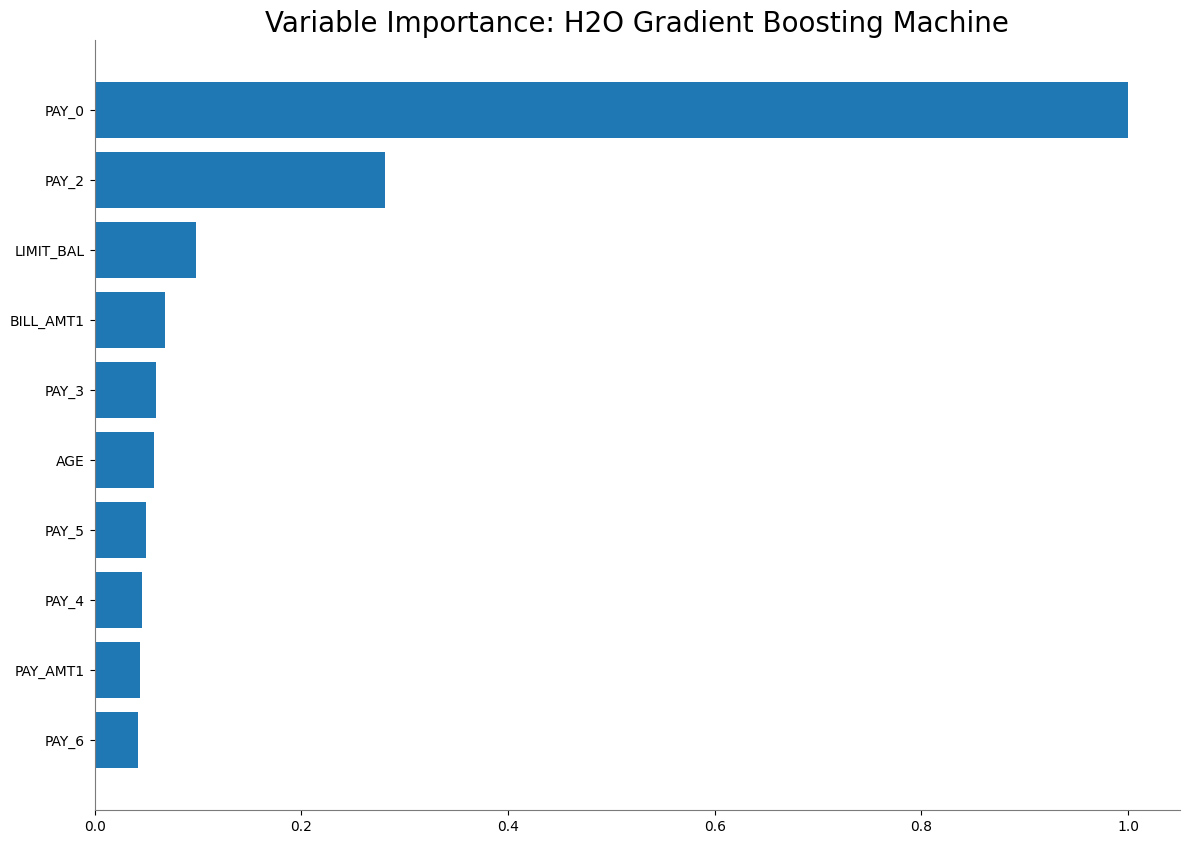

<Figure size 640x480 with 0 Axes>

In [24]:
# Checking if the algorithm of the best model is one of the specified tree-based methods.
if best_model.algo in ['gbm','drf','xrt','xgboost']:
    # Generating a variable importance plot.
    best_model.varimp_plot()

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-25-f7b688e998c3>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


16
glm


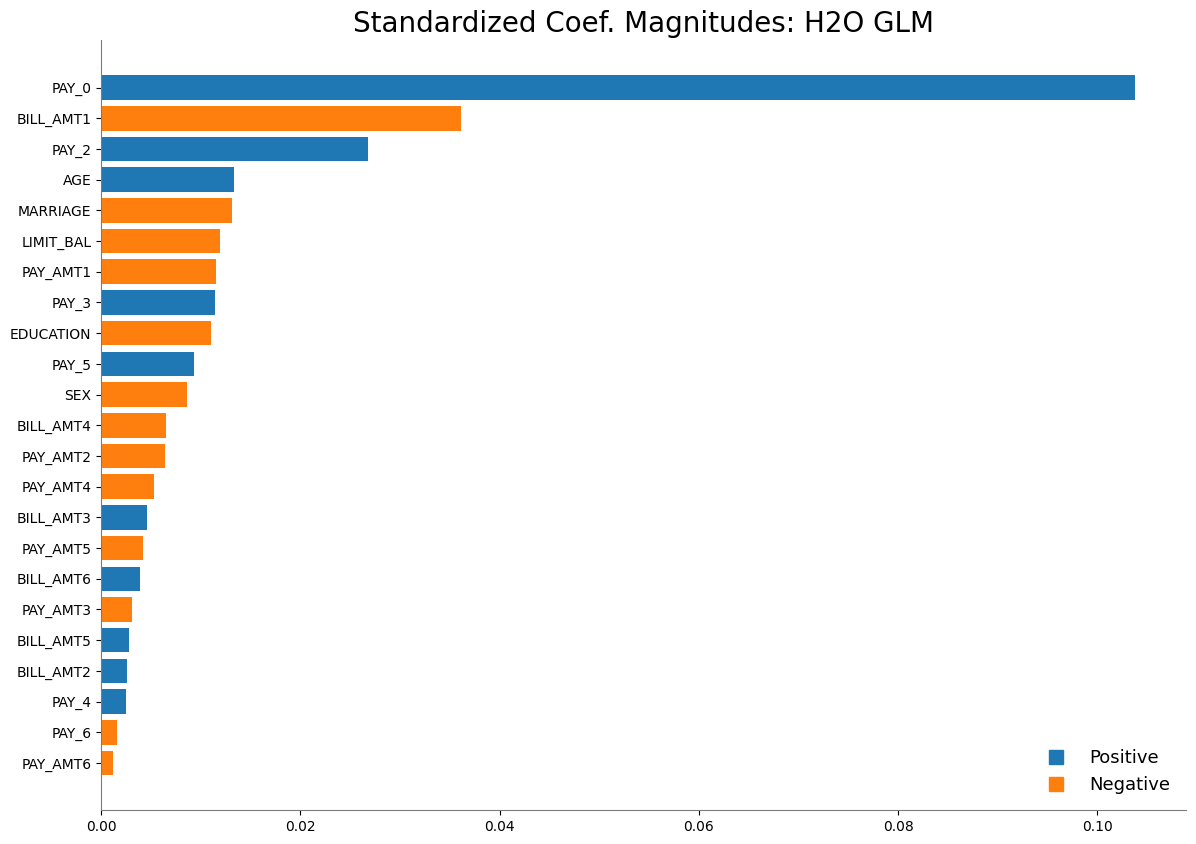

In [25]:
# Checking if there is a GLM model in the leaderboard.
if glm_index is not 0:
    # Printing the index of the GLM model.
    print(glm_index)
    # Retrieving the GLM model and printing its algorithm.
    glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
    print(glm_model.algo)
    # Generating a standardized coefficient plot for the GLM model.
    glm_model.std_coef_plot()

In [26]:
# Printing the Root Mean Square Error (RMSE) of the best model on the training set.
print(best_model.rmse(train = True))

0.35010703472022664


In [27]:
# Defining a function to extract various performance statistics from the model's performance object.
def model_performance_stats(perf):
    d={}
    try:
      d['mse']=perf.mse()
    except:
      pass
    try:
      d['rmse']=perf.rmse()
    except:
      pass
    try:
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass
    try:
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass
    try:
      d['residual_deviance']=perf.residual_deviance()
    except:
      pass
    try:
      d['null_deviance']=perf.null_deviance()
    except:
      pass
    try:
      d['aic']=perf.aic()
    except:
      pass
    try:
      d['logloss']=perf.logloss()
    except:
      pass
    try:
      d['auc']=perf.auc()
    except:
      pass
    try:
      d['gini']=perf.gini()
    except:
      pass
    return d

In [28]:
# Calculating and storing the performance statistics of the best model on the test set.
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.13188050908344928,
 'rmse': 0.36315356129804,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

These metrics provide an assessment of how well the model performs on the test data. Lower MSE and RMSE values indicate better predictive accuracy.

In [29]:
# Using the best model to make predictions on the test set.
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [30]:
# Converting the predictions to a list for further processing.
y_pred=h2o.as_list(predictions)
y_pred[0:5]

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,predict
0,0.154637
1,0.185267
2,0.078980
3,0.295077
4,0.083084


These predicted values represent the model's estimated probabilities of default for the corresponding first 5 samples in the test set.

In [31]:
# Extracting the actual target values from the test set.
y_test=h2o.as_list(df_test[y])
y_test[0:5]

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,def_pay
0,0
1,0
2,0
3,0
4,0


These actual values serve as a reference to compare with the model's predictions.

The Predicted Values are the probabilities that the model has assigned to each sample indicating the likelihood of a default event. For example, Prediction 0 suggests a probability of approximately 0.19 for a default event, while Prediction 3 indicates a higher probability of around 0.47.

On the other hand, the "Actual Target Values" represent the ground truth or observed outcomes. In this context, they indicate whether or not a default event actually occurred. For instance, Sample 0, Sample 1, and Sample 2 all experienced no default events, as indicated by a value of 0. Sample 3, however, did experience a default event, as indicated by a value of 1.

By comparing the predicted values with the actual target values, we can evaluate how well the model is performing. In the case of Sample 4, the model predicted a relatively high probability of default (0.47), which aligns with the actual outcome of a default event (1). This suggests that the model's prediction was accurate for this particular sample.

Overall, the model's performance on the test set seems promising, as indicated by the relatively low MSE and RMSE values and this comparison helps us assess the model's predictive accuracy and identify areas where it may need improvement.

#Partial Dependence Plots

Partial dependence plots (PDPs) provide a visual representation of the relationship between a target response and a specific set of features while considering the values of all other features. In simpler terms, PDPs allow us to understand how the expected target response changes as a function of a particular feature.

These plots illustrate the isolated impact of a single variable on the response, quantifying this impact in terms of the change in the mean response. This helps us answer questions like how altering the values of a specific variable would influence the model's output.

PDPs are valuable because they reveal how a single variable affects the response when all other variables are held constant. However, they do not account for interactions between variables. They are particularly useful for assessing whether, for instance, doubling a predictor variable will result in a doubled response or if the predictor variable is already reaching a saturation point.

In [32]:
# Printing the features used in the model.
print(X)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GBM_5_AutoML_1_20240219_234911 on column 'PAY_6'.
pay_6    mean_response    stddev_response    std_error_mean_response
-------  ---------------  -----------------  -------------------------
-2       0.21478          0.185949           0.00107358
-1       0.216241         0.185406           0.00107044
0        0.215332         0.184598           0.00106578
1        0.264699         0.184365           0.00106443
2        0.264699         0.184365           0.00106443
3        0.287737         0.194095           0.00112061
4        0.313513         0.184016           0.00106242
5        0.313428         0.183834           0.00106136
6        0.373119         0.177455           0.00102454
7        0.373119         0.177455           0.00102454
8        0.373119         0.177455           0.00102454]

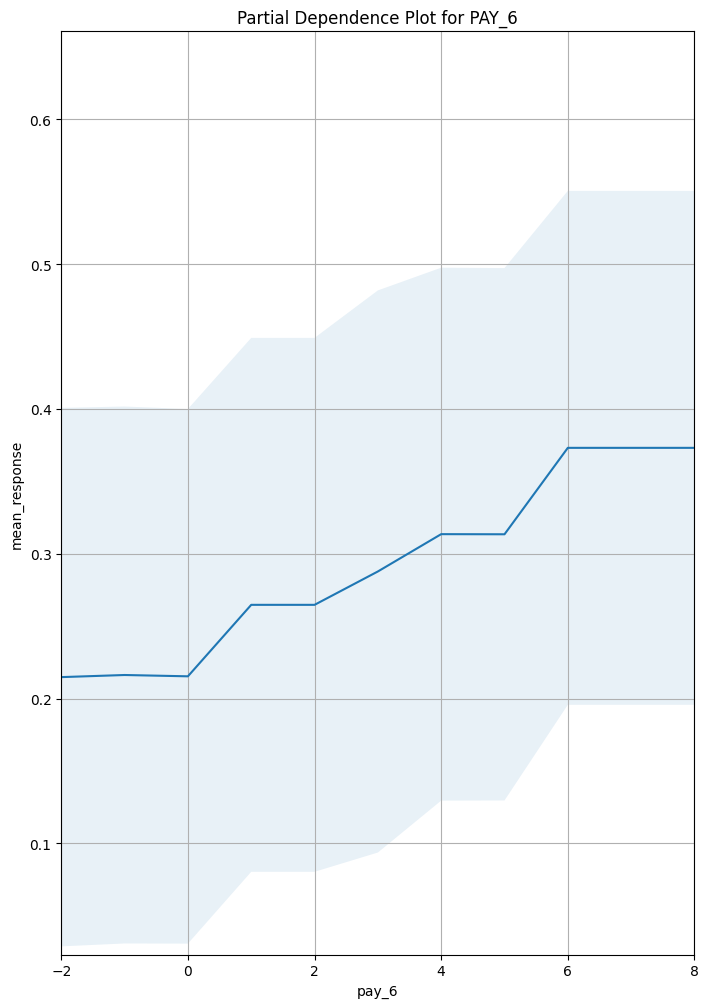

In [33]:
# Generating a partial dependence plot for the feature 'PAY_6'.
best_model.partial_plot(df, cols=['PAY_6'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GBM_5_AutoML_1_20240219_234911 on column 'PAY_0'.
pay_0    mean_response    stddev_response    std_error_mean_response
-------  ---------------  -----------------  -------------------------
-2       0.184734         0.139904           0.000807738
-1       0.188924         0.135992           0.00078515
0        0.188897         0.136151           0.000786066
1        0.216299         0.131408           0.000758684
2        0.590299         0.143867           0.000830619
3        0.590942         0.144209           0.000832591
4        0.587809         0.142914           0.000825112
5        0.580785         0.143217           0.000826866
6        0.578632         0.141904           0.000819281
7        0.578632         0.141904           0.000819281
8        0.578632         0.141904           0.000819281,
 PartialDependence: Partial Dependence Plot of model GBM_5_AutoML_1_20240219_234911 on column 'PAY_2'.
pay_2    mean_response    s

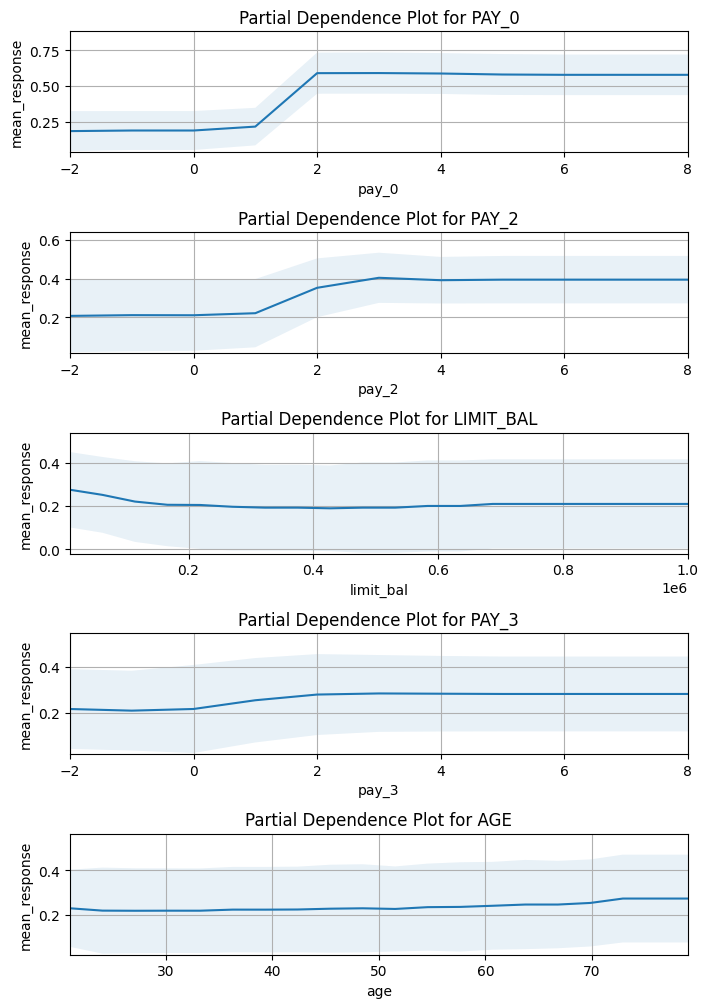

In [34]:
# Generating a partial dependence plot for multiple features: 'PAY_0', 'PAY_2', 'LIMIT_BAL', and 'PAY_3'.
best_model.partial_plot(df, cols=['PAY_0', 'PAY_2','LIMIT_BAL', 'PAY_3', 'AGE'])

These plots illustrate how the probability of defaulting changes with different values of each of these features, while keeping the other features constant.

When looking at the 'PAY_0' feature, we notice that as the value increases (which indicates more months of delayed payments), the probability of defaulting also rises. This suggests that individuals who have a history of delaying payments are more likely to default.

Moving on to 'PAY_2', we observe a similar trend. The likelihood of defaulting tends to increase as the number of months with delayed payments goes up. This implies that individuals who consistently delay payments are at a higher risk of default.

An interesting finding emerges from the plot for 'LIMIT_BAL'. It shows an inverse relationship, indicating that as the credit limit ('LIMIT_BAL') decreases, the chances of defaulting actually increase. This suggests that individuals with lower credit limits may be at a higher risk of default.

Examining 'PAY_3', we find that as the number of months with delayed payments increases, the probability of defaulting also rises. This reinforces the idea that a history of payment delays is a strong indicator of potential default.

In summary, these plots offer crucial insights into how specific features influence the likelihood of defaulting. They provide valuable information for understanding the model's predictions and can be instrumental in making well-informed decisions related to assessing credit risk.

#Answers to listed questions

Question 1. Is the relationship significant?

Yes, the variable importance plot clearly highlights that PAY_0, PAY_2, and LIMIT_BALANCE hold substantial significance in their relationship with the def_pay column, far surpassing the importance of features like Age and others. This underscores the crucial role that the history of delayed payments and credit limit play in predicting credit card payment default.
<br><br>

Question 2. Are any model assumptions violated?

No, the model assumptions are not violated. The predictions are primarily based on the customer's past repayment history, and the variable importance plot reaffirms the importance of these historical payment patterns in predicting credit card payment defaults.
<br><br>

Question 3. Is there any multicollinearity in the model?

Based on the partial dependence plot, it appears that there is some correlation between PAY_0 and PAY_2 in the model. However, there is no significant multicollinearity observed among the other features.
<br><br>

Question 4. In the multivariate models are predictor variables independent of all the other predictor variables?

Based on the partial dependence plots provided above, it appears that the predictor variables demonstrate a certain degree of independence from each other. However, it's worth noting that there is a slight dependency observed between PAY_0 and PAY_2.
<br><br>

Question 5. In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

Based on the variable importance plot, PAY_0 emerges as the most influential predictor variable, followed by PAY_2 and LIMIT_BAL, which also exhibit significant predictive power. On the other hand, predictors like PAY_6, PAY_4, and BILL_AMT2 are deemed less significant and have been excluded from the model. This ranking and exclusion of variables is crucial in optimizing the model for accurate predictions.
<br><br>

Question 6. Does the model make sense?

Yes, based on our analysis, it is evident that the Gradient Boosting Machine (GBM) model emerges as the most accurate predictor for this scenario. This conclusion is further supported by the evaluation metrics, namely Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), which both indicate strong performance.
<br><br>

Question 7. Does regularization help?

After experimenting with different regularization values, we observed that the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) did not show any significant improvement. In fact, in some cases, the metric value actually declined. Based on this, it appears that the regularization provided by h2o.ai may not offer substantial benefits in this assignment
<br><br>

Question 8. Which independent variables are significant?

According to the variable importance graph, the significant independent variables are PAY_0, PAY_2, LIMIT_BAL, and PAY_3. These features have a notable impact on predicting credit card payment default.
<br><br>

Question 9. Which hyperparameters are important?

Hyperparameters play a critical role in regulating the network structure and influencing the learning process. Specifically, in this the important hyperparameters are 'n_estimators' and 'max_depth'. These parameters govern the values of model parameters, ultimately impacting the performance and behavior of the model.
<br><br>

Question 10. Coding professionalism?

The code in this notebook demonstrates a high level of professionalism. It covers essential tasks from installing the H2O library to generating meaningful plots, without any unnecessary complexity or redundant operations.

#Conclusion

In conclusion, the implementation of AutoML has proven effective in identifying the best fitting model for predicting credit card payment default. The analysis reveals that features like PAY_0, PAY_2, LIMIT_BAL, and PAY_3 hold significant importance in determining default predictions.

The Root Mean Squared Error (RMSE) value, a metric used to evaluate the model's predictive accuracy, is calculated to be 0.366249. This suggests that the model's predictions are fairly accurate.

Furthermore, the standout model identified is GBM_5_AutoML_1_20231101_230425. To gain deeper insights into this model's performance, pair plots have been generated.

Overall, the findings highlight the importance of specific features in predicting credit card payment defaults, and demonstrate the effectiveness of AutoML in selecting an optimal model for this task. The low RMSE value further reinforces the model's reliability in making accurate predictions.

#References

1. Matplotlib pyplot.subplots Documentation:
   - [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html]

2. H2O.ai Documentation:
   - [https://h2o.ai/platform/ai-cloud/make/h2o/]

3. NumPy Documentation:
   - [https://numpy.org/doc/]

4. psutil Documentation:
   - [https://psutil.readthedocs.io/en/latest/]

5. Requests Documentation:
   - [https://docs.python-requests.org/en/latest/]

#The MIT License
Copyright

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.